# Lab. 8 Autoencoders

![Auto-encoder](utils/ae.png)


"Vanilla" autoenkodery minimalizują tzw. _reconstruction error_, najczęściej wyrażony w postaci błędu średniokwadratowego liczonego pomiędzy oryginalnym wejściem i rekonstrukcją.

<font size=4>
$$ \mathcal{L}(x, dec(enc(x))) = ||x - dec(enc(x))||^2 $$
</font>

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składam się z tych samych transformacji co enkoder w odwrtonej kolejności.  

**Pytanie:** Co mogłoby się stać gdybyśmy nie "zwężali" enkodera? 


### Setup i dane

In [10]:
%matplotlib inline

from utils.draw_utils import plot_digits

import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [11]:
next(iter(train_loader))[0].shape

torch.Size([64, 784])

## Zadanie 1: Vanilla Autoencoder

Zaimplementować Autoenkoder z 5 warstwami liniowymi (z nieliniową aktywacją np. `tanh`) w enkoderze: 
   * wejściowa (rozmiar cyfry z MNISTA)
   * rozmiaru 128
   * rozmiaru 64
   * rozmiaru 12
   * rozmiaru `latent_dim`
oraz dekoderem z dokładnie odwrotnym przekształceniem.
    
**Pytanie:** Jaka powinna być funkcja aktywacji na wyjściu dekodera? 

In [16]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, self.latent_dim),
          ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 784),
            nn.Sigmoid()
          )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        en_out = self.encode(x)
        de_out = self.decode(en_out)
        return en_out, de_out 

## Zadanie 2: Pętla Uczenia
Uzupełnić brakujące fragmenty kodu uczenia.

Epoch:  0 | train loss: 0.2313


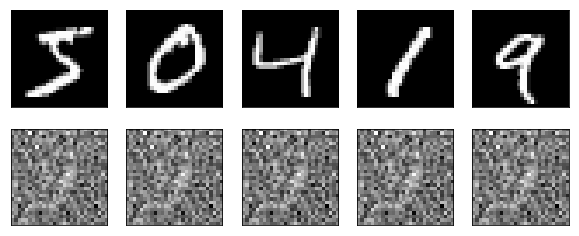

Epoch:  0 | train loss: 0.0550


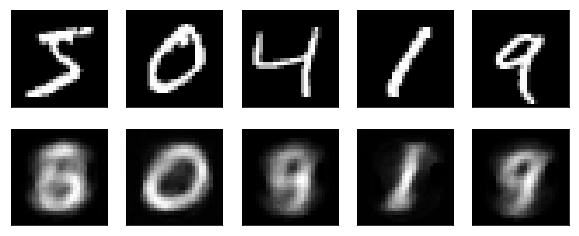

Epoch:  5 | train loss: 0.0435


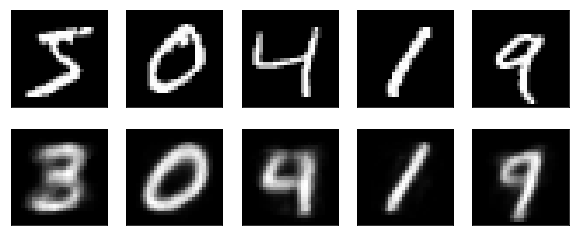

Epoch:  5 | train loss: 0.0399


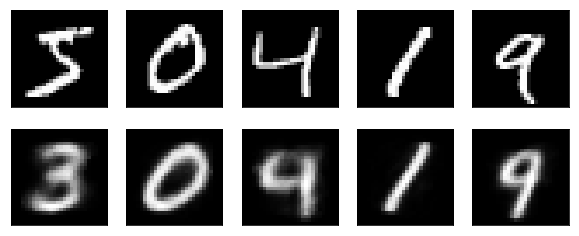

Epoch:  9 | train loss: 0.0403


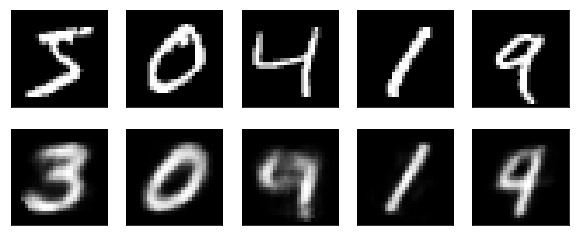

Epoch:  9 | train loss: 0.0388


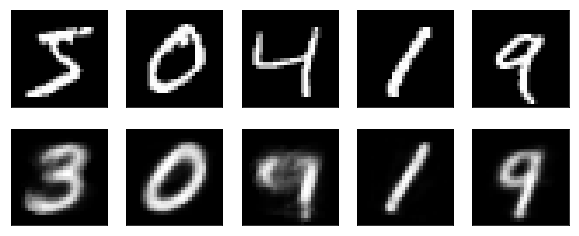

In [17]:
# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 5

# prepare original data for plotting
view_data = train_data.train_data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.

autoencoder = AutoEncoder(latent_dim=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()


for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded = autoencoder(x) 

        loss = loss_func(decoded, x) 
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            plot_digits(view_data, decoded_data)

# Zadanie 3: "Generowanie" z Autoenkodera

Teoretycznie nasz "vanilla" autoenkoder nie ma naturalnych właściwości generatywnych (więcej w przyszłości przy VAE), ale mimo to spróbujmy wygenerować z niego nowe przykłady.

1. Załóżmy, że nasz autoenkoder układa dane "w środku" w rozkład normalny. Waszym zadaniem jest oszacowanie średniej i wariancji tego rozkładu dla `n` przykładów ze zbioru trenującego. Należy to zrobić na podstawie części zbioru trenującego.

In [24]:
samples = []
n = 500

for step, (x, y) in enumerate(train_loader):
    
    if len(samples) > n:
        break
    en_x, _ = autoencoder(x)
    samples.append(en_x.detach().numpy())
    # encode the points into the latent space and save for later estimation
    
sampled_z = np.concatenate(samples, axis=0)

# compute mean and std of the empirical distribution in the latent space 
mean_z = sampled_z.mean()  
std_z = sampled_z.std() 

2. Używając rozkładu normalnego sparametryzowanego policzonymi momentami wylosuj kilka przykład i zwizualizuj ich rekonstrukcje.

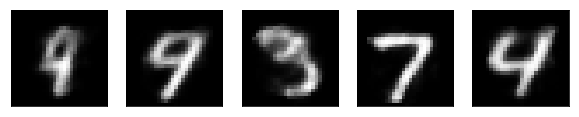

In [44]:
z_sampled = torch.distributions.Normal(mean_z, std_z)
z_sampled = z_sampled.sample((5,3))
x_decoded = autoencoder.decode(z_sampled) # decode the sampled points

plot_digits(x_decoded)

## Zadanie 4. Interpolacja

Dla kilku przykładów ze zbioru trenującego zaimplementuj interpolacje pomiedzy parą punktów w przestrzeni _latent_, następnie zdekoduj te interpolacje i zwizualizuj wynik. Dla przypomnienie, liniowa interpolacja:

<br>

<font size=4>
$$ \forall \lambda \in [0,1] \quad f_L(x_1, x_2, \lambda) =  (1 - \lambda) x_1 + \lambda x_2 $$
</font>

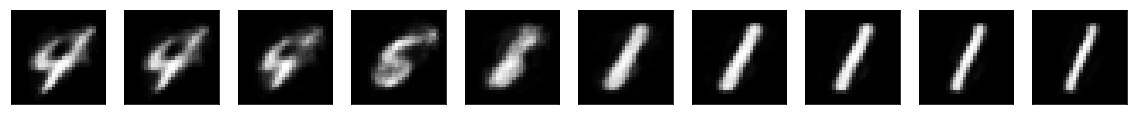

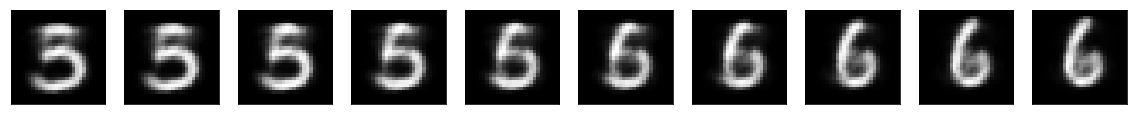

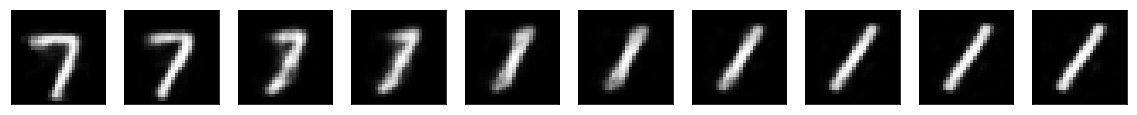

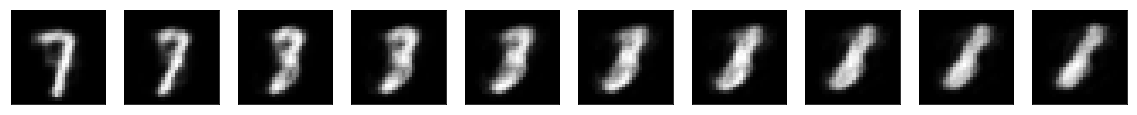

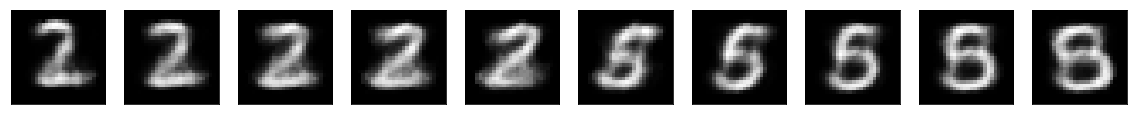

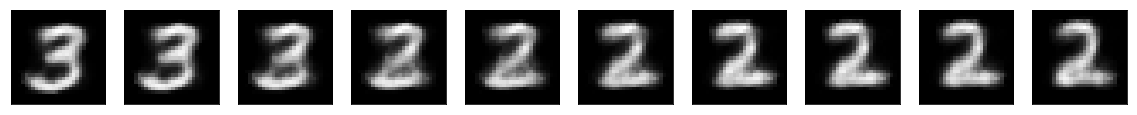

In [40]:
n_interpolations = 5

for step, (x, y) in enumerate(train_loader):
    if step > n_interpolations:
        break
    
    x_1 = x[0, :]
    x_2 = x[1, :]
    
    z_1 = autoencoder.encode(x_1)
    z_2 = autoencoder.encode(x_2)
    
    x_interpolated = []
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1 - alpha) * z_1 + alpha * z_2 # interpolate in the latent space
        x_int = autoencoder.decode(z_int) # decode the interpolated sample
        
        x_interpolated.append(x_int)
    
    x_interpolated = torch.stack(x_interpolated, dim=0)
    
    plot_digits(x_interpolated)
